# Texas Timeseries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Loading data

In [2]:
df_emp=pd.read_pickle("emp_dfpkl.sec")

In [3]:
df_emp= df_emp[['Michigan','California','Ohio','Texas','Indiana']]

In [4]:
emp_final= df_emp[238:]

#### Indiana Dataset

In [6]:
texas=emp_final['Texas']

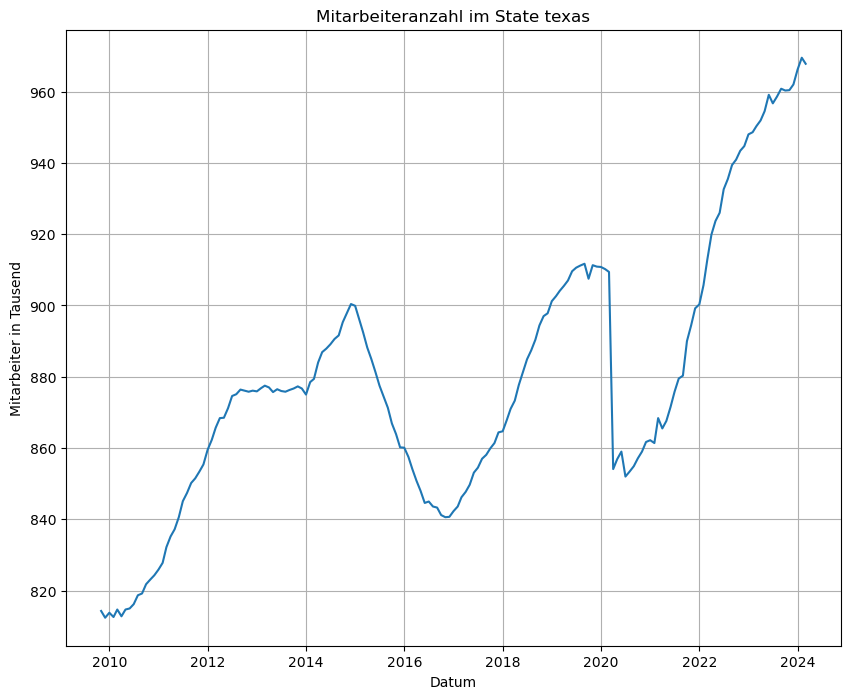

In [7]:
plt.figure(figsize=(10, 8))
plt.plot(texas)
plt.title('Mitarbeiteranzahl im State texas')
plt.xlabel('Datum')
plt.ylabel('Mitarbeiter in Tausend')
plt.grid(True)
plt.show()

### Test und Trainingsdaten

In [8]:
#Test und Traingsdaten
train = texas[:int(0.9 * len(texas))]
test = texas[int(0.9 * len(texas)):]

In [9]:
pred_start= test.index[0]
pred_end= test.index[-1]

In [10]:
print(f"Länge des Trainingsdatensatzes: {len(train)}")
print(f"Länge des Testdatensatzes: {len(test)}")

Länge des Trainingsdatensatzes: 155
Länge des Testdatensatzes: 18


# Samira

### Besteht aus ARIMA (AR -> Autoregression, I -> Differenzierung und MA-> Gleitender Durschschnitt) plus Saisonale Komponenten S auf ARIMA 

## 1. Stationary

In [11]:
result = adfuller(texas)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -1.0655122896277553
p-value: 0.728627493504266


keine stationarity

In [12]:
texas_diff= texas.diff().dropna()

In [13]:
result = adfuller(texas_diff)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -5.186460701538381
p-value: 9.369259295332538e-06


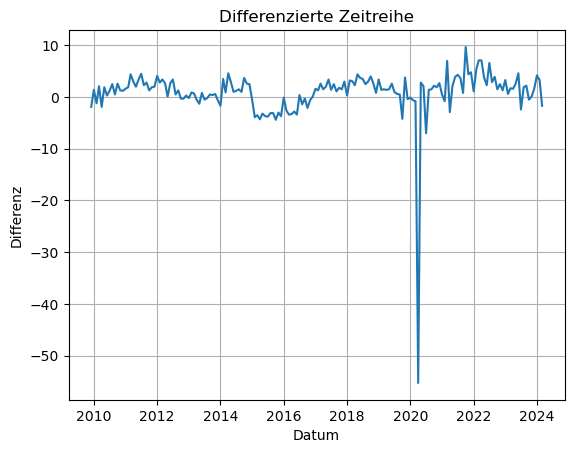

In [14]:
plt.plot(texas_diff)
plt.title('Differenzierte Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.grid(True)
plt.show()

## 2. PACF und ACF

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

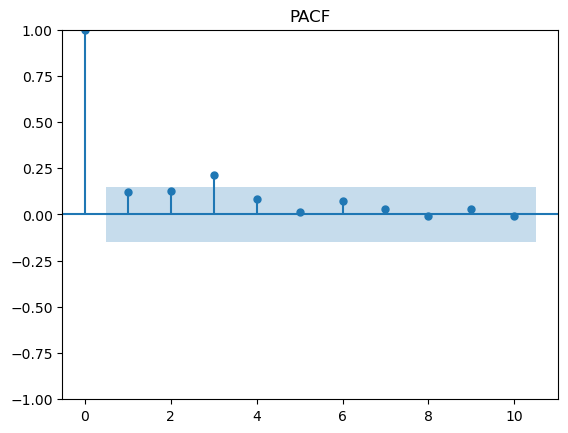

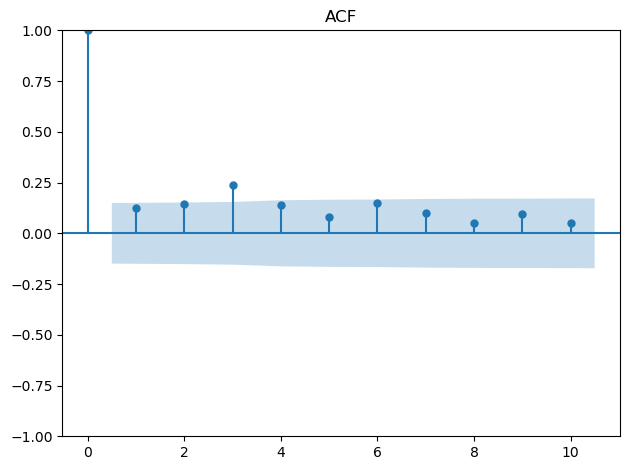

In [16]:
plot_pacf(texas_diff,lags=10,title='PACF')
plot_acf(texas_diff,lags=10,title='ACF')
plt.tight_layout()
plt.show()

PACF= 3, ACF=3

### Gleitender Durchschnitt mit rolling window

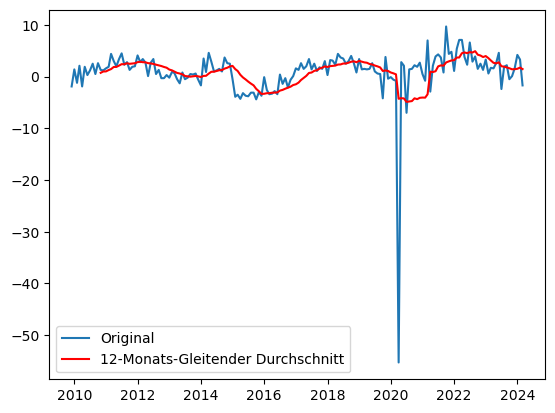

In [17]:
MA = texas_diff.rolling(window=12).mean()
plt.plot(texas_diff, label='Original')
plt.plot(MA, label='12-Monats-Gleitender Durchschnitt', color='red')
plt.legend()
plt.show()

### Gleitender durschnitt mit ARIMA

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [21]:
#MA_modell= ARIMA(train,order=(0,0,2)) # -> nur MA berechnung
MA_modell= ARIMA(train,order=(0,0,3)) # -> nur MA berechnung

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [22]:
MA_fit= MA_modell.fit()
print(MA_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Texas   No. Observations:                  155
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -565.040
Date:                Sat, 05 Oct 2024   AIC                           1140.079
Time:                        23:42:37   BIC                           1155.296
Sample:                    11-01-2009   HQIC                          1146.260
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        870.1985      3.119    278.961      0.000     864.085     876.312
ma.L1          1.3847      0.042     33.246      0.000       1.303       1.466
ma.L2          1.1547      0.064     18.144      0.0

P > Z sagt aus welche Lags signifikant sind. alles unter 0.05 sind nicht signifikant

In [23]:
ma_pred=MA_fit.predict(start=pred_start, end= pred_end)
residuals=test-ma_pred

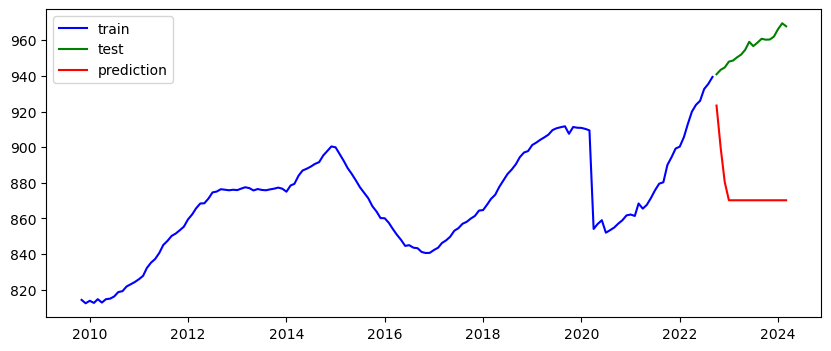

In [24]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ma_pred, label='prediction',color='red')
plt.legend()
plt.show()

# AR -> Autoregression 

In [36]:
ar_modell= ARIMA(train,order=(3,0,0))
ar_fit=ar_modell.fit()
print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Texas   No. Observations:                  155
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -476.610
Date:                Sat, 05 Oct 2024   AIC                            963.220
Time:                        23:43:51   BIC                            978.437
Sample:                    11-01-2009   HQIC                           969.401
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        873.8004     43.091     20.278      0.000     789.344     958.257
ar.L1          1.1231      0.053     21.186      0.000       1.019       1.227
ar.L2          0.0213      0.066      0.324      0.7

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Prediction with Ar models

In [37]:
ar_pred=ar_fit.predict(start=pred_start, end= pred_end)
residuals=test-ar_pred

Ploting

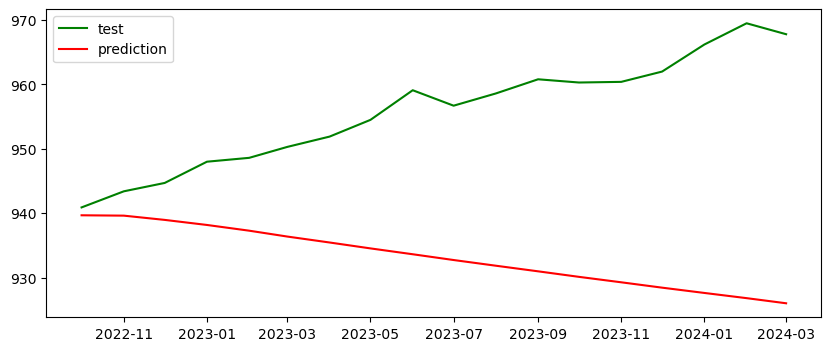

In [38]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ar_pred, label='prediction',color='red')
plt.legend()
plt.show()

### Evaulation

In [39]:
test_mae = mean_absolute_error(test, ar_pred)
test_mse = mean_squared_error(test, ar_pred)
test_rmse = mean_squared_error(test, ar_pred, squared=False)
test_r2 = r2_score(test, ar_pred)

In [40]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 22.567284946474487
mse 668.3793017173313
rmse 25.853032737327574
r2 -8.836961052166075


# Arima (p,d,q)

In [41]:
arima_modell= ARIMA(train, order=(3,1,3)) 
arima_fit=arima_modell.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Texas   No. Observations:                  155
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -466.382
Date:                Sat, 05 Oct 2024   AIC                            946.764
Time:                        23:48:53   BIC                            968.023
Sample:                    11-01-2009   HQIC                           955.399
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2314      0.357      0.648      0.517      -0.468       0.931
ar.L2         -0.2311      0.384     -0.602      0.547      -0.984       0.521
ar.L3          0.6972      0.323      2.155      0.0

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [42]:
arima_pred=arima_fit.predict(start=pred_start, end= pred_end)
residuals=test-arima_pred

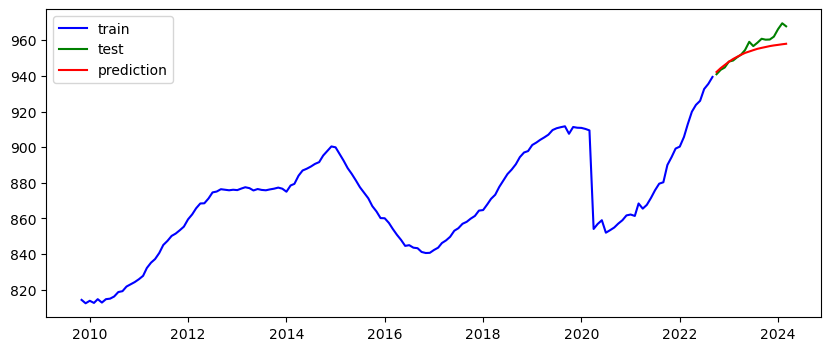

In [43]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( arima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [44]:
test_mae = mean_absolute_error(test, arima_pred)
test_mse = mean_squared_error(test, arima_pred)
test_rmse = mean_squared_error(test, arima_pred, squared=False)
test_r2 = r2_score(test, arima_pred)

In [45]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 3.661801606933169
mse 24.86196194739185
rmse 4.986177087448043
r2 0.6340907764071368


# Sarima (p,d,q)(P,D,Q)s

In [46]:
my_order = (3,1,3)
my_sorder = (1,1,1,12)

In [47]:
sarima_modell = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
sarima_fit=sarima_modell.fit()
print(sarima_fit.summary())

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                Texas   No. Observations:                  155
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -443.825
Date:                              Sat, 05 Oct 2024   AIC                            905.651
Time:                                      23:49:23   BIC                            932.253
Sample:                                  11-01-2009   HQIC                           916.461
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2792      0.408      0.684      0.494      -0.520       1.079
ar.L2         -0.31

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
sarima_pred=sarima_fit.predict(start=pred_start, end= pred_end)
residuals=test-sarima_pred

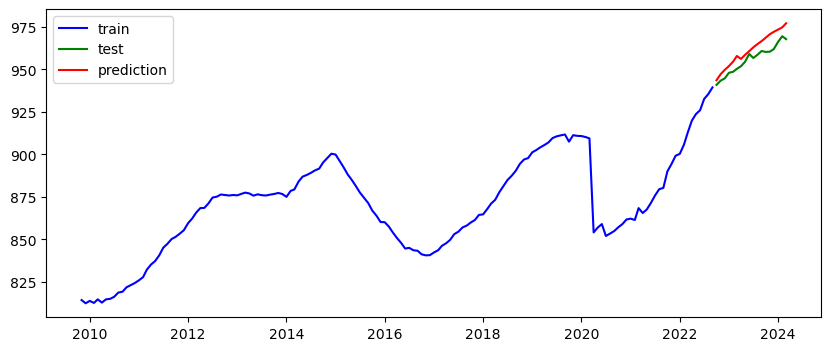

In [49]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [50]:
test_mae = mean_absolute_error(test, sarima_pred)
test_mse = mean_squared_error(test, sarima_pred)
test_rmse = mean_squared_error(test, sarima_pred, squared=False)
test_r2 = r2_score(test, sarima_pred)

In [51]:
print('mae',test_mae)
print('mse',test_mse)
print('MSE', round(np.mean(abs(residuals/test)),4))
print('rmse',test_rmse)
print('r2',test_r2)

mae 5.996876262088942
mse 41.6885933385871
MSE 0.0063
rmse 6.456670452995653
r2 0.38644259638562994


# Auto Sarima

In [52]:
import pmdarima as pm

In [53]:
auto_sarima = pm.auto_arima(train,d=None, stationary= False,
                           m=12, start_p=0, max_p=11, max_d= 1,approximation = True, start_q=0, max_q=11, start_P=0, D=None, start_Q=0, max_P=11, max_D=1, max_Q=11, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=950.327, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=951.048, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=951.245, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=952.004, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=951.722, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=951.433, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=950.758, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=949.868, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=950.749, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=950.702, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=949.211, Time=0.04 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=950.402, Time=0.10 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=950.160, Time=0.07 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=950.486, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[12] intercep

In [54]:
my_order = (3,1,0)
my_sorder = (0,0,0,12)

In [55]:
a_sarima = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
auto_s_fit = a_sarima.fit()
print(auto_s_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Texas   No. Observations:                  155
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -467.674
Date:                Sat, 05 Oct 2024   AIC                            943.348
Time:                        23:49:58   BIC                            955.496
Sample:                    11-01-2009   HQIC                           948.283
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0928      0.055      1.684      0.092      -0.015       0.201
ar.L2          0.1179      0.053      2.228      0.026       0.014       0.222
ar.L3          0.2246      0.089      2.516      0.0

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [56]:
auto_sarima_pred=auto_s_fit.predict(start=pred_start, end= pred_end)
residuals=test-auto_sarima_pred

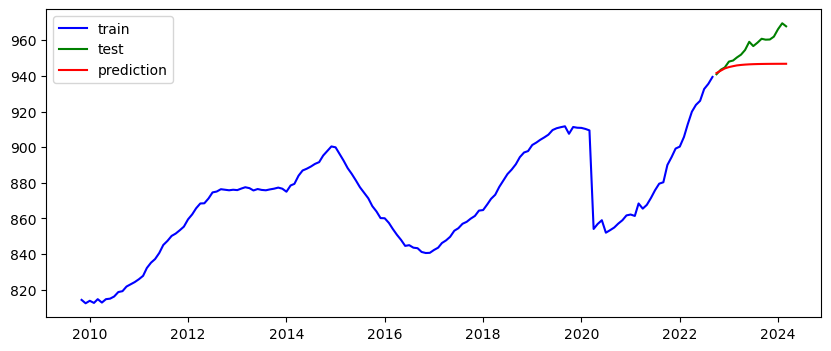

In [58]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( auto_sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [59]:
test_mae = mean_absolute_error(test, auto_sarima_pred)
test_mse = mean_squared_error(test, auto_sarima_pred)
test_rmse = mean_squared_error(test, auto_sarima_pred, squared=False)
test_r2 = r2_score(test, auto_sarima_pred)

In [60]:
print('mae',test_mae)
print('mse',test_mse)
print('MSE', round(np.mean(abs(residuals/test)),4))
print('rmse',test_rmse)
print('r2',test_r2)

mae 10.05401197719406
mse 149.27026091564431
MSE 0.0105
rmse 12.217620918805933
r2 -1.1969048698860778
